In [4]:
!conda install diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

Retrieving notices: ...working... done
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - pyarrow==9.0.0

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




https://huggingface.co/settings/tokens

In [1]:
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    batch_size = 32
    num_epochs = 100
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision

    device = "cuda"
    random_state = 42 


config = TrainingConfig()

In [2]:
import os
import random

import numpy as np
import torch


def seed_everything(seed: int,
                    use_deterministic_algos: bool = False) -> None:
    
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(use_deterministic_algos)
    random.seed(seed)
    
   
seed_everything(config.random_state)

# Utils

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im
    


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

# Data

In [4]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("food101", split='train')

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images, "label": examples["label"]}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=config.batch_size, shuffle=True
)

In [5]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")

Noisy X shape torch.Size([8, 3, 128, 128])


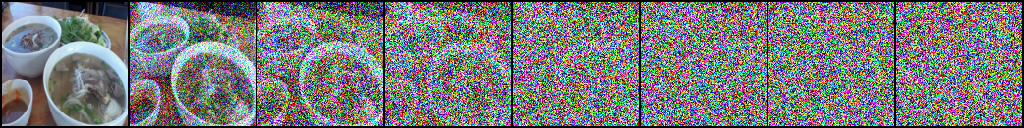

In [6]:
x = next(iter(train_dataloader))["images"][:1].repeat(8, 1, 1, 1)
timesteps = torch.linspace(0, 999, 8).long()
noise = torch.randn_like(x)
noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
print("Noisy X shape", noisy_x.shape)
show_images(noisy_x).resize((8 * 128, 128), resample=Image.NEAREST)

In [7]:
next(iter(train_dataloader))

{'images': tensor([[[[-0.4118, -0.5137, -0.3804,  ..., -0.2078, -0.1922, -0.1843],
           [-0.1294, -0.4667, -0.4275,  ..., -0.1451, -0.1373, -0.1451],
           [-0.1294, -0.4196, -0.4588,  ..., -0.1294, -0.1294, -0.1373],
           ...,
           [ 0.0039,  0.0118,  0.0118,  ..., -0.3176, -0.4902, -0.5843],
           [ 0.0196,  0.0196,  0.0118,  ..., -0.5373, -0.6314, -0.6549],
           [ 0.0275,  0.0275,  0.0196,  ..., -0.6314, -0.6549, -0.6706]],
 
          [[-0.2627, -0.3333,  0.0745,  ..., -0.2157, -0.2000, -0.1922],
           [ 0.0275, -0.3333, -0.0431,  ..., -0.1843, -0.1765, -0.2000],
           [ 0.0510, -0.3020, -0.1686,  ..., -0.1765, -0.2000, -0.2314],
           ...,
           [ 0.0431,  0.0431,  0.0510,  ..., -0.2549, -0.4196, -0.5059],
           [ 0.0275,  0.0431,  0.0431,  ..., -0.4667, -0.5294, -0.5294],
           [ 0.0275,  0.0353,  0.0431,  ..., -0.5451, -0.5137, -0.4902]],
 
          [[ 0.0588,  0.1765,  0.7020,  ..., -0.4431, -0.4275, -0.4039],
   

# Model

In [8]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    num_class_embeds=101,
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)

# Let's Trains

In [9]:
from diffusers import DDPMPipeline
from tqdm.auto import tqdm 

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, 
    beta_schedule="linear"
)

noise_scheduler.set_timesteps(num_inference_steps=1000)

noise_scheduler.timesteps

tensor([999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986,
        985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972,
        971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958,
        957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944,
        943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930,
        929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916,
        915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902,
        901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888,
        887, 886, 885, 884, 883, 882, 881, 880, 879, 878, 877, 876, 875, 874,
        873, 872, 871, 870, 869, 868, 867, 866, 865, 864, 863, 862, 861, 860,
        859, 858, 857, 856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846,
        845, 844, 843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832,
        831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 8

In [10]:
noise_scheduler.num_inference_steps, noise_scheduler.num_train_timesteps

/home/lazarev/miniconda3/envs/ftcp/lib/python3.11/site-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


(1000, 1000)

In [11]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [12]:
from accelerate import Accelerator

accelerator = Accelerator(
    mixed_precision=config.mixed_precision,
    gradient_accumulation_steps=config.gradient_accumulation_steps, 
)

train_dataloader, model, optimizer = accelerator.prepare(
    train_dataloader, model, optimizer
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [13]:
def generate(x, model, noise_scheduler, num_inference_steps: int = 1000):
    model.eval()

    bs = x.shape[0]

    y = torch.randint(
            0, 101, (bs,), device=config.device
        ).long()
    
    noise_scheduler.set_timesteps(num_inference_steps=num_inference_steps)

    for t in tqdm(noise_scheduler.timesteps):
        model_input = noise_scheduler.scale_model_input(x, t)

        t_batch = torch.full(
            size=(bs,), 
            fill_value=t.item(), 
            dtype=torch.long
        ).cuda()

        with torch.no_grad():
            noise_pred = model(
                model_input, 
                t_batch, 
                y,
                return_dict=False
            )[0]

        x = noise_scheduler.step(noise_pred, t, x).prev_sample

    return x

In [ ]:
losses = []

for epoch in range(100):
    for batch in tqdm(train_dataloader):
        clean_images = batch["images"].to(config.device)
        labels = batch["label"].to(config.device)
        
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(config.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=config.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
                    
        with accelerator.accumulate(model):
            noise_pred = model(
                noisy_images, 
                timesteps, 
                labels,
                return_dict=False
            )[0]
    
            # Calculate the loss
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)
            losses.append(loss.item())
    
            # Update the model parameters with the optimizer
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
        
    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch + 1}, loss: {loss_last_epoch}")

        generated = generate(
            torch.randn((16, 3, 128, 128)).cuda(), 
            model, 
            noise_scheduler,
            num_inference_steps=100
        ).cpu()
        pil_images = show_images(generated)
        plt.imshow(pil_images)

        torch.save(model, f"food101_conditional_ddpm/model_{epoch}.pt")

  0%|          | 0/2368 [00:00<?, ?it/s]

  0%|          | 0/2368 [00:00<?, ?it/s]

  0%|          | 0/2368 [00:00<?, ?it/s]

  0%|          | 0/2368 [00:00<?, ?it/s]

  0%|          | 0/2368 [00:00<?, ?it/s]

Epoch:5, loss: 0.019675073327144254


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2368 [00:00<?, ?it/s]

  0%|          | 0/2368 [00:00<?, ?it/s]

  0%|          | 0/2368 [00:00<?, ?it/s]

  0%|          | 0/2368 [00:00<?, ?it/s]

  0%|          | 0/2368 [00:00<?, ?it/s]

Epoch:10, loss: 0.018968448931224662


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2368 [00:00<?, ?it/s]

  0%|          | 0/2368 [00:00<?, ?it/s]

  0%|          | 0/2368 [00:00<?, ?it/s]

In [ ]:
pil_images